In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

We consider a simple regression problem. We want to estimate y given x.

The data is generated by the following model:
f(x) = 1 + x + 3 $x^2$ + 0.3 e

, which can be decomposed into two parts:
* true_f(x) = 1+ x + 3  $x^2$  is deterministic, so for given $x_0$ it always returns the same value
* e - is a random variable given by the triangular distribution with min=-1, mode=0, max =1

In [21]:
def true_f(x):
    return np.polynomial.polynomial.polyval(x, [1,1,3])

def noise(x, fraction = 0.3):
    return  fraction * np.random.triangular(-1,0,1,len(x))

def f(x):
    return true_f(x) + noise(x)

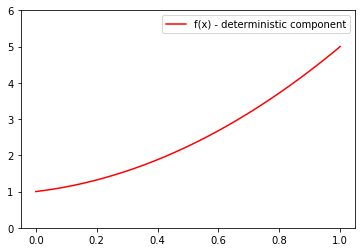

In [22]:
x = np.linspace(0,1.,100000)
y = true_f(x)

plt.plot(x, y, label = "f(x) - deterministic component", color='red')
plt.ylim(0,6)
plt.legend(loc="best")
plt.show()

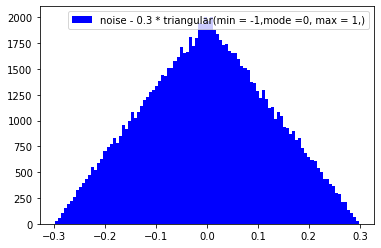

In [23]:

nevents =100000
plt.hist(noise(range(nevents)),bins=100, label = "noise - 0.3 * triangular(min = -1,mode =0, max = 1,)", color='blue')
plt.legend(loc="best")
plt.show()


In the languange of Statistical Learning Theory our (unknown) distribution Z = X $\times$ Y is described by the pdfs:
* p(y,x) = p(x) * p(y|x)

We will assume that there is no uncertainty in the sampling procedure, which mean that e.g. for our training set we will always get the same sets of x values p($x_0$)=1 for chosen $x_0$.

* The conditional pdf for given $x_0$ is p(y|$x_0$) = 1 + $x_0$ + 3 $x_0^2$ + 0.3 e

The pdf p(y|$x_0$) = 1 + $x_0$ + 3 $x_0^2$ + 0.3 e corresponds clearly to a triangular distribution with parameters: mode = f($x_0$), min =f($x_0$) - 0.3, max = f($x_0$) + 0.3



2.25


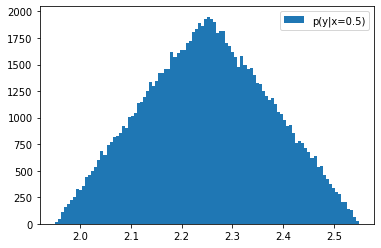

In [24]:
#For x0 = 0.5
x= [0.5 for _ in range(100000)]
y_true =true_f(0.5)
print(y_true)
y = f(x)
plt.hist(y, bins=100, label = "p(y|x=0.5)")
plt.legend(loc="best")
plt.show()

In [25]:
def getSample(nSamples = 100, f = true_f, noise = noise):
  x = np.linspace(0,1.,nSamples)
  return x, f(x) + noise(x)

In [26]:
N = 100
x_train, y_train = getSample(nSamples = N)

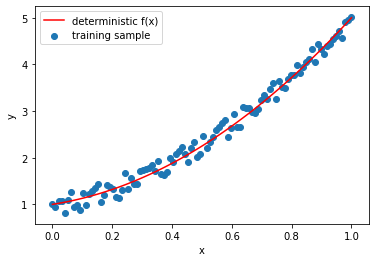

In [27]:
plt.figure()
plt.scatter(x_train, y_train, label = "training sample")
plt.plot(x_train, true_f(x_train), label="deterministic f(x)", color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc="best")
plt.show()

Let's assume that we train a simple Linear Regression to our data:
* $ h(x) = p_0 + p_1 *x$

We will LinearRegression from sklearn library.
There is one small technical detail. The input of x values should be in the form [[1], [2], [3] ], where 1,2,3 ale consecutive values of x, so this example corresponds to N of samples equal 3. We will hide it in a small function

In [28]:
model=LinearRegression()

In [29]:
def train(N, model):
    x_train, y_train = getSample(nSamples = N)
    x = [[val]  for val in x_train]
    y = y_train
    model.fit(x, y)
    return x,y

In [30]:
def plotTrained(x,y, model):
    plt.scatter(x,y,color='blue', label='training data')
    plt.plot(x,model.predict(x), label="fitted model h(x) = p0 + p1 *x", color='red')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.ylim(0,6)
    plt.legend(loc="best")
    plt.show()

In [31]:
def printInfo(model,x,y):
    print('%f + x* %f'%(model.intercept_,model.coef_[0]))
    print('Training error E_T:%f'%mean_squared_error(y, model.predict(x)))

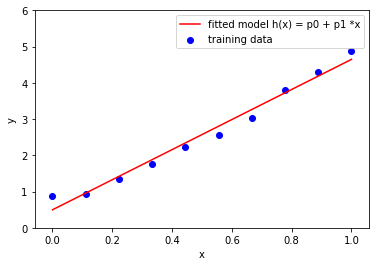

0.496625 + x* 4.151114
Training error E_T:0.036410


In [32]:
x,y = train(10,model)
plotTrained(x,y, model)
printInfo(model,x,y)

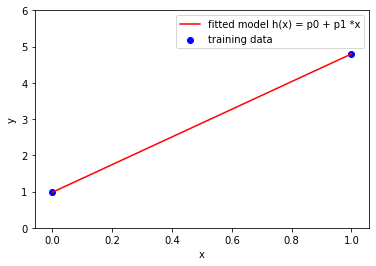

0.982116 + x* 3.816319
Training error E_T:0.000000


In [33]:
# For two points we get perfect ET
x,y = train(2,model)
plotTrained(x,y, model)
printInfo(model,x,y)

In [34]:
# Since we know the true function we can calculate the average error of it
x,y = getSample(10000000)
y_true = true_f(x)
E_true = mean_squared_error(y,y_true)
print(E_true)

0.015005597095221682


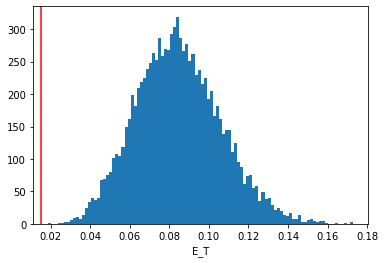

In [35]:
#Training error is a random variable itself !
E_T = []
for _ in range(10000):
    x,y = train(10,model)
    E_T.append(mean_squared_error(y, model.predict(x)))
plt.hist(E_T, bins=100)
plt.axvline(x=E_true, color='r', linestyle='-')
#plt.axhline(y=0.5, color='r', linestyle='-')
plt.xlabel('E_T')
plt.show()

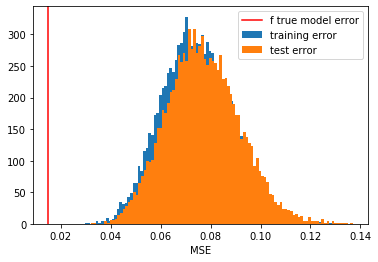

0.07642055741864626
0.0736843929103182


In [36]:
#what about the test error

E_train=[]
E_test=[]

N_train = 20
N_test = 20
for _ in range(10000):
    x,y = train(N_train,model)
    E_train.append(mean_squared_error(y, model.predict(x)))
    x_test, y_test = getSample(nSamples = N_test)
    x_test= [[v] for v in x_test]
    E_test.append(mean_squared_error(y_test, model.predict(x_test)))
plt.hist(E_train, bins=100, label='training error')
plt.hist(E_test, bins=100, label='test error')
plt.axvline(x=E_true, color='r', linestyle='-', label='f true model error')
plt.xlabel('MSE')
plt.legend(loc="best")
plt.show()
print(np.median(E_test))
print(np.median(E_train))

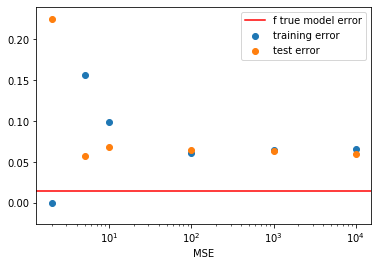

0.06587664915294222
0.05944154766194609


In [37]:
E_train = []
E_test=[]
Nvals = [2,5,10,100,1000, 10000]
for N in Nvals:
    x,y = train(N,model)
    E_train.append(mean_squared_error(y, model.predict(x)))
    x_test, y_test = getSample(nSamples = 100)
    x_test= [[v] for v in x_test]
    E_test.append(mean_squared_error(y_test, model.predict(x_test)))

plt.scatter(Nvals,E_train, label='training error')
plt.scatter(Nvals,E_test, label='test error')
plt.axhline(y=E_true, color='r', linestyle='-', label='f true model error')
plt.xlabel('MSE')
plt.xscale('log')
plt.legend(loc="best")
plt.show()
print(E_train[5])
print(E_test[5])

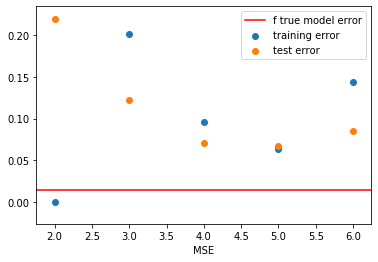

In [38]:
E_train = []
E_test=[]
Nvals = [2,3,4,5,6]
for N in Nvals:
    x,y = train(N,model)
    E_train.append(mean_squared_error(y, model.predict(x)))
    x_test, y_test = getSample(nSamples = 100)
    x_test= [[v] for v in x_test]
    E_test.append(mean_squared_error(y_test, model.predict(x_test)))

plt.scatter(Nvals,E_train, label='training error')
plt.scatter(Nvals,E_test, label='test error')
plt.axhline(y=E_true, color='r', linestyle='-', label='f true model error')
plt.xlabel('MSE')
plt.legend(loc="best")
plt.show()